In [1]:
import sys
import math
import random
import time
from PIL import Image
from multiprocessing import Queue
import numpy as np
import threading
from io import BytesIO
import tensorflow as tf
# import tensorflow as tf


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# checking if connected to gpu

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# downloading data to notebook directory

# !wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy

In [ ]:
# import just women fashion

!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy

--2022-04-20 13:54:36--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy [following]
--2022-04-20 13:54:36--  https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6644545540 (6.2G)
Saving to: ‘AmazonWomenWithImgPartitioned.npy’

nWomenWithImgPartit  84%[===============>    ]   5.21G  17.0MB/s    eta 63s    

### TO DO

In [ ]:
# create copy of dataset
# check if same product id are in train, validate, and test sets
# create code to sample product from dataset
# show image for product, description, category
# let jen input rating
# save product info with rating to train, validate, and test
# create script to train model on new updated data

In [8]:
# dataset_name = 'AmazonFashion6ImgPartitioned.npy'

# dataset_name = '/home/scotsditch/stuff/scotsditch_storage/dvbpr/DVBPR/AmazonFashion6ImgPartitioned.npy'

dataset_name = '/home/scotsditch/stuff/scotsditch_storage/dvbpr/jen_rate/AmazonFashion6ImgPartitioned.npy'

In [9]:
dataset = np.load(dataset_name, encoding='bytes',allow_pickle=True)

In [10]:
[user_train, user_validation, user_test, Item, usernum, itemnum] = dataset

In [ ]:
#Hyper-prameters
K = 100 # Latent dimensionality
lambda1 = 0.001 # Weight decay
lambda2 = 1.0 # Regularizer for theta_u
learning_rate = 1e-4
training_epoch = 20
batch_size = 128
dropout = 0.5 # Dropout, probability to keep units
numldprocess=4 # multi-threading for loading images

## Data Exploration:

In [11]:
print('length user_train: {}'.format(len(user_train)))
print('length user_validation: {}'.format(len(user_validation)))
print('length user_test: {}'.format(len(user_test)))
print('length Item: {}'.format(len(Item)))
print('usernum: {}'.format(usernum))
print('itemnum: {}'.format(itemnum))

length user_train: 45184
length user_validation: 45184
length user_test: 45184
length Item: 166270
usernum: 45184
itemnum: 166270


In [ ]:
# Note: usernum and itemnum are just numbers, total count of users and items

In [29]:
print('user_train')
display(user_train[0])

print('user_validation')
display(user_validation[0])

print('user_test')
display(user_test[0])

print('Item')
display(Item[0])




user_train


[{'reviewerID': 'A1JWX45KHE34AL',
  'asin': 'B00APT3MHO',
  'reviewerName': 'varnienarsil',
  'helpful': [0, 0],
  'reviewText': "Good for someone who likes skinny jeans but doesn't look great in the legging-tight ones. A little stretchy. Not super tight in the knee or ankle, but snug on the thigh and calf.",
  'overall': 5.0,
  'summary': 'Love these jeans',
  'unixReviewTime': 1384646400,
  'reviewTime': '11 17, 2013',
  b'productid': 1},
 {'reviewerID': 'A1JWX45KHE34AL',
  'asin': 'B00CJ5NH36',
  'reviewerName': 'varnienarsil',
  'helpful': [0, 0],
  'reviewText': "This shirt with it's bold graphic is seriously adorable. I have pretty narrow shoulders, and like the way the sleeves slope off them. The shirt fits loosely in a way that is flattering and I liked the length. I'm no model, but the shirt looks on me as great as it looks in the photo.",
  'overall': 5.0,
  'summary': 'As cute as it looks',
  'unixReviewTime': 1384646400,
  'reviewTime': '11 17, 2013',
  b'productid': 2},
 {

user_validation


[{'reviewerID': 'A1JWX45KHE34AL',
  'asin': 'B00CP11HK4',
  'reviewerName': 'varnienarsil',
  'helpful': [0, 0],
  'reviewText': 'This is an intense shirt. The yellow is even brighter than in the photo. The arms were too small for me to button, but they fold up nicely. Will probably wear more in the summer or under a muted sweater if I find an appropriate one to go with this shirt.',
  'overall': 3.0,
  'summary': 'Bright!',
  'unixReviewTime': 1384646400,
  'reviewTime': '11 17, 2013',
  b'productid': 3}]

user_test


[{'reviewerID': 'A1JWX45KHE34AL',
  'asin': 'B008986OXM',
  'reviewerName': 'varnienarsil',
  'helpful': [0, 0],
  'reviewText': "1) Buy a size up! I bought Cheap Monday jeans that I love in one size and ordered the Cheap Monday Women's Tight Fit Jean, Hard Coated in the same size. Couldn't button it up. The next size up fit, but was really tight.2) The material is beautiful. It's thin with a hard coating that gives the jeans a bit of a matte-leather feel, without being quite as outrageous as leather.3) The fit wasn't that flattering for me (I'm pretty slim and look good in any skinny jeans that aren't super tight in the knee), especially in the upper thigh and knee, where the jeans were quite tight.",
  'overall': 2.0,
  'summary': 'Great material, poor fit',
  'unixReviewTime': 1384646400,
  'reviewTime': '11 17, 2013',
  b'productid': 0}]

Item


{b'asin': b'B008986OXM',
 b'c': array([False, False, False,  True, False, False]),
 b'title': b"Cheap Monday Women's Tight Fit Jean, Hard Coated, 27",
 b'imUrl': b'http://ecx.images-amazon.com/images/I/31bmhqq5IXL._SX342_.jpg',
 b'imgs': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x05\x05\x06\x07\x0c\x08\x07\x07\x07\x07\x0f\x0b\x0b\t\x0c\x11\x0f\x12\x12\x11\x0f\x11\x11\x13\x16\x1c\x17\x13\x14\x1a\x15\x11\x11\x18!\x18\x1a\x1d\x1d\x1f\x1f\x1f\x13\x17"$"\x1e$\x1c\x1e\x1f\x1e\xff\xdb\x00C\x01\x05\x05\x05\x07\x06\x07\x0e\x08\x08\x0e\x1e\x14\x11\x14\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\xff\xc0\x00\x11\x08\x01\xbc\x01V\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\

In [14]:
print('user_train')
display(user_train[1])

print('user_validation')
display(user_validation[1])

print('user_test')
display(user_test[1])

print('Item')
display(Item[1])

user_train


[{'reviewerID': 'A2YHF6O2D37PMX',
  'asin': 'B000LYFF46',
  'reviewerName': 'DCP',
  'helpful': [0, 0],
  'reviewText': "I selected &#34;fit as expected&#34;, but they just are not comfortable.  There is a ridge inside the top of the heel.  It feels lumpy and digs in a little.  The arch support feels inadequate.  Maybe the heel would soften, but I won't risk it and will return them.",
  'overall': 3.0,
  'summary': 'Just not comfortable for me',
  'unixReviewTime': 1393804800,
  'reviewTime': '03 3, 2014',
  b'productid': 5},
 {'reviewerID': 'A2YHF6O2D37PMX',
  'asin': 'B005FPAC8K',
  'reviewerName': 'DCP',
  'helpful': [3, 3],
  'reviewText': "May 27:  I've worn them 3-4 times each since May 7, and I have to lower my original rating from 3 stars to 1.  I wore the blue pair for shopping yesterday and came home in pain.  They have stretched so badly that I was walking awkwardly.  I'd have had better control with flipflops and more comfort being barefoot.  In addition, the footbed felt h

user_validation


[{'reviewerID': 'A2YHF6O2D37PMX',
  'asin': 'B007U1XMUC',
  'reviewerName': 'DCP',
  'helpful': [1, 1],
  'reviewText': "If I didn't wear fairly heavy socks in the winter, it probably would have fit fine.  I should have thought of that and order the next size up.",
  'overall': 4.0,
  'summary': 'Almost great',
  'unixReviewTime': 1384646400,
  'reviewTime': '11 17, 2013',
  b'productid': 8}]

user_test


[{'reviewerID': 'A2YHF6O2D37PMX',
  'asin': 'B009DNPN48',
  'reviewerName': 'DCP',
  'helpful': [4, 6],
  'reviewText': "The sandal looks fine, but it is too wide.  My feet are average-to-narrow.  I ordered a narrow, but it is at least as wide as footwear I've had to order as medium because narrow was not available.  I don't dislike the sandal, but I can't give it even 3 stars because it does not fit at all.  I have always loved Softspots, but over the last few years I haven't been able to find any that are as nice as the ones I used to buy.  Makes me think the company has been sold or outsourced.  That was a silly comment, wasn't it.  Of course the work has almost certainly been outsourced.",
  'overall': 2.0,
  'summary': 'Narrow is wide',
  'unixReviewTime': 1365552000,
  'reviewTime': '04 10, 2013',
  b'productid': 9}]

Item


{b'asin': b'B00APT3MHO',
 b'c': array([False, False, False,  True, False, False]),
 b'title': b"Cheap Monday Women's Skinny Tight Jean",
 b'price': 62.4,
 b'imUrl': b'http://ecx.images-amazon.com/images/I/31hFOdT1iiL._SX342_.jpg',
 b'related': {b'also_bought': [b'B007R9TAR6']},
 b'imgs': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x05\x05\x06\x07\x0c\x08\x07\x07\x07\x07\x0f\x0b\x0b\t\x0c\x11\x0f\x12\x12\x11\x0f\x11\x11\x13\x16\x1c\x17\x13\x14\x1a\x15\x11\x11\x18!\x18\x1a\x1d\x1d\x1f\x1f\x1f\x13\x17"$"\x1e$\x1c\x1e\x1f\x1e\xff\xdb\x00C\x01\x05\x05\x05\x07\x06\x07\x0e\x08\x08\x0e\x1e\x14\x11\x14\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\xff\xc0\x00\x11\x08\x01\xbc\x01V\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x

In [24]:
# check if different products 
# in user_train, user_validation, user_test, Item, usernum, itemnum

# check_train=[{'reviewerID':x[i]['reviewerID'],'asin':x[i]['asin']} 
#              for x in user_train
#              for i in x]

check_all_train=[]

for k in user_train:

    check_train=[]

    test_x=user_train[k]

    for i in range(len(test_x)):

        check_train=check_train+[{'reviewerID':test_x[i]['reviewerID'],'asin':test_x[i]['asin']}]


    check_all_train=check_all_train+check_train
    
check_all_train[:20]

[{'reviewerID': 'A1JWX45KHE34AL', 'asin': 'B00APT3MHO'},
 {'reviewerID': 'A1JWX45KHE34AL', 'asin': 'B00CJ5NH36'},
 {'reviewerID': 'A1JWX45KHE34AL', 'asin': 'B00F9NGAPM'},
 {'reviewerID': 'A2YHF6O2D37PMX', 'asin': 'B000LYFF46'},
 {'reviewerID': 'A2YHF6O2D37PMX', 'asin': 'B005FPAC8K'},
 {'reviewerID': 'A2YHF6O2D37PMX', 'asin': 'B007IL5PW2'},
 {'reviewerID': 'A2YHF6O2D37PMX', 'asin': 'B00DX9QC2K'},
 {'reviewerID': 'A2YHF6O2D37PMX', 'asin': 'B00DX9SZ7A'},
 {'reviewerID': 'ASSFVTXVRP2TJ', 'asin': 'B002MH3OH0'},
 {'reviewerID': 'ASSFVTXVRP2TJ', 'asin': 'B004AS1GQU'},
 {'reviewerID': 'ASSFVTXVRP2TJ', 'asin': 'B004WK8RQS'},
 {'reviewerID': 'ASSFVTXVRP2TJ', 'asin': 'B004Z4I4G4'},
 {'reviewerID': 'ASSFVTXVRP2TJ', 'asin': 'B007XODRQU'},
 {'reviewerID': 'A1J2PAQ53MO4BS', 'asin': 'B002SB9R4O'},
 {'reviewerID': 'A1J2PAQ53MO4BS', 'asin': 'B005WJLPU8'},
 {'reviewerID': 'A1J2PAQ53MO4BS', 'asin': 'B00BUKM1TW'},
 {'reviewerID': 'A1J2PAQ53MO4BS', 'asin': 'B00INCX1IU'},
 {'reviewerID': 'AL8K3UN5THEN0', 'as

In [25]:
check_all_validation=[]

for k in user_validation:

    check_validation=[]

    test_x=user_validation[k]

    for i in range(len(test_x)):

        check_validation=check_validation+[{'reviewerID':test_x[i]['reviewerID'],'asin':test_x[i]['asin']}]


    check_all_validation=check_all_validation+check_validation

In [26]:
print(len([x for x in check_all_train if x not in check_all_validation]))

267635


In [46]:
print(len(check_all_train))

267635


In [32]:
Item[0].keys()

dict_keys([b'asin', b'c', b'title', b'imUrl', b'imgs', b'salesRank', b'categories'])

In [40]:
# distinct categories

categories=[Item[i][b'categories'] for i in range(len(Item))]

print(len(categories))

categories[:5]

# filter for just item that contain b'Women'

166270


[[[b'Clothing, Shoes & Jewelry', b'Women', b'Clothing', b'Jeans'],
  [b'Clothing, Shoes & Jewelry', b'Women', b'Petite', b'Jeans']],
 [[b'Clothing, Shoes & Jewelry', b'Women', b'Clothing', b'Jeans'],
  [b'Clothing, Shoes & Jewelry', b'Women', b'Petite', b'Jeans']],
 [[b'Clothing, Shoes & Jewelry',
   b'Women',
   b'Clothing',
   b'Tops & Tees',
   b'Knits & Tees']],
 [[b'Clothing, Shoes & Jewelry',
   b'Women',
   b'Clothing',
   b'Tops & Tees',
   b'Blouses & Button-Down Shirts']],
 [[b'Clothing, Shoes & Jewelry',
   b'Women',
   b'Clothing',
   b'Tops & Tees',
   b'Knits & Tees']]]

In [116]:


women_itemnums=[]


for k in range(len(Item)):
    
    for x in Item[k][b'categories']:

        if b'Women' in x:

            women_itemnums.append(k)
    
women_itemnums=list(set(women_itemnums))
    
    
        
        
        
#         if b'Petite' in x[k][b'categories']:
                         
#                          print(x[k][b'categories'])


In [117]:
len(women_itemnums)

119118

In [ ]:
# Note: check datasets, might already have one filtered for women's products

# get asin values for women_itemnums
# randomly sample from train, validation, test
# get asin
# check if asin item is in women_itemnums
# if not, resample from list
# show item, title and category
# input box to prompt for number of stars
# save rating dict to jen train, validation, test
# each time rating check existing jen ratings to see item num isn't in there
# save jen train, validation, test out

(-0.5, 341.5, 423.5, -0.5)

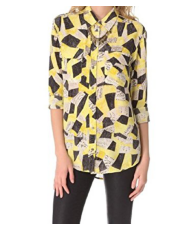

In [118]:
# view item

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


img = np.asarray(Image.open(BytesIO(Item[3][b'imgs'])))
plt.imshow(img)
plt.axis('off')
   

In [99]:
Item[0]

{b'asin': b'B008986OXM',
 b'c': array([False, False, False,  True, False, False]),
 b'title': b"Cheap Monday Women's Tight Fit Jean, Hard Coated, 27",
 b'imUrl': b'http://ecx.images-amazon.com/images/I/31bmhqq5IXL._SX342_.jpg',
 b'imgs': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x05\x05\x06\x07\x0c\x08\x07\x07\x07\x07\x0f\x0b\x0b\t\x0c\x11\x0f\x12\x12\x11\x0f\x11\x11\x13\x16\x1c\x17\x13\x14\x1a\x15\x11\x11\x18!\x18\x1a\x1d\x1d\x1f\x1f\x1f\x13\x17"$"\x1e$\x1c\x1e\x1f\x1e\xff\xdb\x00C\x01\x05\x05\x05\x07\x06\x07\x0e\x08\x08\x0e\x1e\x14\x11\x14\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\xff\xc0\x00\x11\x08\x01\xbc\x01V\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\

In [59]:
# [x[i] for x in categories[:5][i] 
#  for i in range(len(categories[:5][0])) 
#  if b'Petite' in categories[:5][i] 
#  ]

# for i in range(5):
    
#     print([x for x in categories[i] if b'Petite' in x ])




[[b'Clothing, Shoes & Jewelry', b'Women', b'Petite', b'Jeans']]
[[b'Clothing, Shoes & Jewelry', b'Women', b'Petite', b'Jeans']]
[]
[]
[]


In [45]:
jen_items=[Item[i][b'asin'] for i in range(len(Item)) if b'Women' in Item[i][b'categories']]

jen_items[:5]

[]

### Women products

In [120]:
dataset_name = '/home/scotsditch/stuff/scotsditch_storage/dvbpr/DVBPR/AmazonWomenWithImgPartitioned.npy'

dataset = np.load(dataset_name, encoding='bytes',allow_pickle=True)

[user_train, user_validation, user_test, Item, usernum, itemnum] = dataset


print('length user_train: {}'.format(len(user_train)))
print('length user_validation: {}'.format(len(user_validation)))
print('length user_test: {}'.format(len(user_test)))
print('length Item: {}'.format(len(Item)))
print('usernum: {}'.format(usernum))
print('itemnum: {}'.format(itemnum))
print('')

print('user_train')
display(user_train[0])

print('user_validation')
display(user_validation[0])

print('user_test')
display(user_test[0])

print('Item')
display(Item[0])

length user_train: 97678
length user_validation: 97678
length user_test: 97678
length Item: 347591
usernum: 97678
itemnum: 347591

user_train


[{'reviewerID': 'ABO9R96QKYO8K',
  'asin': 'B006E8BTM0',
  'reviewerName': 'Deb',
  'helpful': [0, 0],
  'reviewText': "I absolutely love these pj bottoms. They are very roomy and warm. I had read other reviews that they are not as presentable for company. But these are built for warmth and comfort and believe they appear as the picture shows. I would have bought more but my only concern is how they will hold up with multiple Washings as some  parts of the material seems thinner than others. But even if not,  it is we'll worth the money if you are looking for warmth and comfort.",
  'overall': 5.0,
  'summary': 'Pants',
  'unixReviewTime': 1350259200,
  'reviewTime': '10 15, 2012',
  b'productid': 2},
 {'reviewerID': 'ABO9R96QKYO8K',
  'asin': 'B007Q2O45C',
  'reviewerName': 'Deb',
  'helpful': [1, 1],
  'reviewText': 'The pendant arrived quicker than expected. I really like the pendant inside the heart. Chain seems sturdy for being a thinner chain. The only downside, is the pendant is

user_validation


[{'reviewerID': 'ABO9R96QKYO8K',
  'asin': 'B001I6POTC',
  'reviewerName': 'Deb',
  'helpful': [7, 8],
  'reviewText': 'Love this baby blue color. I had the same style of slippers that I was trying to replace. Ordered a med (based on the size chart) I am a 7.5 but were to small, so had to go back.',
  'overall': 3.0,
  'summary': 'Slippers',
  'unixReviewTime': 1350259200,
  'reviewTime': '10 15, 2012',
  b'productid': 0}]

user_test


[{'reviewerID': 'ABO9R96QKYO8K',
  'asin': 'B004EHE1V4',
  'reviewerName': 'Deb',
  'helpful': [0, 0],
  'reviewText': 'I purchased a large size. But the pants run very small. They look like they would fit someone a size four. Other that that, they are as appears in the picture.',
  'overall': 2.0,
  'summary': 'Pants',
  'unixReviewTime': 1350259200,
  'reviewTime': '10 15, 2012',
  b'productid': 1}]

Item


{b'asin': b'B001I6POTC',
 b'title': b'Plush Signature Slippers - 100% Soft Micro-fleece House Slippers',
 b'imUrl': b'http://ecx.images-amazon.com/images/I/41kYHkPZbnL._SY395_.jpg',
 b'related': {b'also_bought': [b'B000EVKO8I',
   b'B002YT2IJQ',
   b'B000EVHPMQ',
   b'B003K18J86',
   b'B006OY37V0',
   b'B00376M1HY',
   b'B0049198JA',
   b'B000P32BBI',
   b'B004W1KGA2',
   b'B004K6L83I',
   b'B00A81QP5K'],
  b'also_viewed': [b'B003K18J86',
   b'B006OY37V0',
   b'B0049198JA',
   b'B004W1KGA2',
   b'B00EJFHO2O',
   b'B007SUC3XW',
   b'B004W60D2I',
   b'B00IE0GB1U',
   b'B00EJTRVN2',
   b'B00HUERTQ2',
   b'B006OY38EQ',
   b'B00EZSA5Q2',
   b'B00JOEUJ3Q',
   b'B00LI1LLWG',
   b'B00EJFI5CW',
   b'B004VJSSUK',
   b'B00EJFI6U8',
   b'B006OY37WO',
   b'B00AAMPO0O',
   b'B004W60D0U',
   b'B00LI6IWKU',
   b'B002OSWPT0',
   b'B00FK3XMDY',
   b'B00HXP87KA',
   b'B000EVKO8I',
   b'B00842Z7GS',
   b'B001I629AE',
   b'B005E2JGR2',
   b'B00FEOOZGW',
   b'B0093OGSSC',
   b'B00B5SYWTQ',
   b'B001E1WHEQ',

In [ ]:
# ToDo:
# randomly sample from itemnum

# get asin values for train, validation, test
# randomly sample from train, validation, test
# get asin
# if already in jen rated list, resample from list
# show item, title and category
# input box to prompt for number of stars
# save rating dict to jen train, validation, test
# each time rating check existing jen ratings to see item num isn't in there
# save jen train, validation, test out

In [130]:
# getting asin values from user_train

train_asin=[]

for k in range(len(user_train)):
    
    for i in range(len(user_train[k])):
        
        train_asin.append(user_train[k][i]['asin'])
        
train_asin=list(set(train_asin))

In [128]:
# getting asin values from user_validation

validation_asin=[]

for k in range(len(user_validation)):
    
    for i in range(len(user_validation[k])):
        
        validation_asin.append(user_validation[k][i]['asin'])
        
validation_asin=list(set(validation_asin))

In [131]:
# getting asin values from user_test

test_asin=[]

for k in range(len(user_test)):
    
    for i in range(len(user_test[k])):
        
        test_asin.append(user_test[k][i]['asin'])
        
test_asin=list(set(test_asin))

In [135]:
# function to randomly sample from list

# import random

# test_jen_list=['B007HESHJS']

# new_asin=random.choice(test_asin)

# while new_asin in test_jen_list:
    
#     new_asin=random.choice(test_asin)
    
# print(new_asin) 


def rand_samp(test_list,source_list):
    
    import random

    new_asin=random.choice(source_list)

    while new_asin in test_list:

        new_asin=random.choice(source_list)

    return new_asin 
    
    
    
rand_samp(test_list=['B007HESHJS'],source_list=test_asin)    


'B001AY9ICG'

B007BF34GY
Title:
b'Original Tibetan Jade Bead Tibet Handcrafted Green Jade Bracelet Handmade'

Categories:
[[b'Clothing, Shoes & Jewelry', b'Women'], [b'Clothing, Shoes & Jewelry', b'Novelty, Costumes & More', b'Novelty', b'Jewelry', b'Bracelets']]



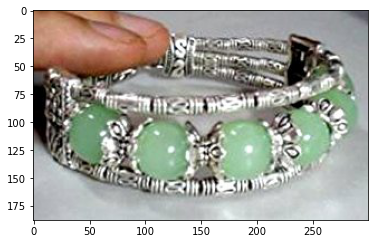

'B007BF34GY'

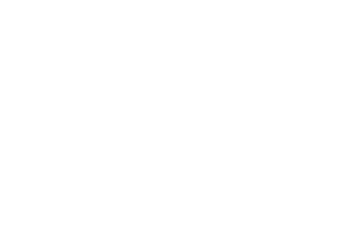

In [182]:
# get product info and pic of product

# To Do:
# from Items:
# b'asin
# b'title
# b'imgs
# b'Categories

# use asin to filter Items for item
# print b'title and b'categories
# show b'imgs

# # get asin value
# match_asin=rand_samp(test_list=['B007HESHJS'],source_list=test_asin)
# print(match_asin)
                        
# # return values for matching asin value
# for k in range(len(Item)):
    
#     if Item[k][b'asin'].decode()==match_asin:
        
# #         print(Item[k][b'asin'])
        
#         print('Title:')
#         print(Item[k][b'title'])
#         print('')
#         print('Categories:')
#         print(Item[k][b'categories'])
#         print('')
#         import matplotlib.pyplot as plt
#         from matplotlib.pyplot import figure


#         img = np.asarray(Image.open(BytesIO(Item[k][b'imgs'])))
#         plt.imshow(img)
#         plt.axis('off')
        
        
        
def show_item(tst_lst,src_lst):
    
    match_asin=rand_samp(test_list=tst_lst,source_list=src_lst)
    print(match_asin)

    # return values for matching asin value
    for k in range(len(Item)):

        if Item[k][b'asin'].decode()==match_asin:

    #         print(Item[k][b'asin'])

            print('Title:')
            print(Item[k][b'title'])
            print('')
            print('Categories:')
            print(Item[k][b'categories'])
            print('')
            
            import matplotlib.pyplot as plt
            from matplotlib.pyplot import figure

            
            img = np.asarray(Image.open(BytesIO(Item[k][b'imgs'])))
            plt.imshow(img)
            
            plt.show(block=False)
            plt.pause(0.1)
            plt.axis('off')
            
            return match_asin
    

show_item(tst_lst=['B007HESHJS'],src_lst=test_asin)

In [159]:
# get productid based on asin

for k in range(len(user_test)):
    
    for i in user_test[k]:
        if i['asin']=='B00CHSENE2':
            print(i[b'productid'])

168003


B000CESTIY
Title:
b"Calvin Klein Women's 3 Pack Wide Rib Casual"

Categories:
[[b'Clothing, Shoes & Jewelry', b'C', b'Calvin Klein'], [b'Clothing, Shoes & Jewelry', b'Women', b'Clothing', b'Socks & Hosiery', b'Casual Socks'], [b'Clothing, Shoes & Jewelry', b'Women', b'Petite', b'Socks & Hosiery', b'Casual Socks']]



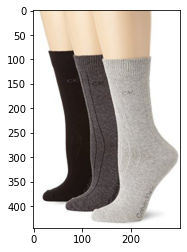

Number of stars 1-5: 2


{'reviewerID': 'SNUGLEBUTT123',
 'asin': 'B000CESTIY',
 'reviewerName': 'SNUGLEBUTT',
 'helpful': [1, 1],
 'reviewText': 'SNUGLEBUTT',
 'summary': 'SNUGLEBUTT',
 'unixReviewTime': 1652111139,
 'reviewTime': '05, 09, 2022',
 b'productid': 929,
 'overall': 2.0}

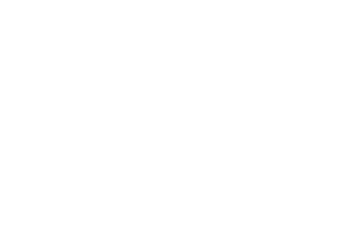

In [185]:
# [{'reviewerID': 'ABO9R96QKYO8K',
#   'asin': 'B006E8BTM0',
#   'reviewerName': 'Deb',
#   'helpful': [0, 0],
#   'reviewText': "I absolutely love these pj bottoms. They are very roomy and warm. I had read other reviews that they are not as presentable for company. But these are built for warmth and comfort and believe they appear as the picture shows. I would have bought more but my only concern is how they will hold up with multiple Washings as some  parts of the material seems thinner than others. But even if not,  it is we'll worth the money if you are looking for warmth and comfort.",
#   'overall': 5.0,
#   'summary': 'Pants',
#   'unixReviewTime': 1350259200,
#   'reviewTime': '10 15, 2012',
#   b'productid': 2},
 
 
# from datetime import datetime
 
# #current date and time
# now = datetime.now()
# #date format: mm-dd-yyyy
# format = "%m, %d, %Y"
# #format datetime using strftime() 
# date1 = now.strftime(format)
 
 
# itm_dct={}
# itm_dct['reviewerID']='SNUGLEBUTT123'
# itm_dct['asin']=match_asin
# itm_dct['reviewerName']='SNUGLEBUTT'
# itm_dct['helpful']=[1,1]
# itm_dct['reviewText']='SNUGLEBUTT'

# itm_dct['summary']='SNUGLEBUTT'
# itm_dct['unixReviewTime']=int(time.time())
# itm_dct['reviewTime']=date1

 
 
# # get productid based on asin

# for k in range(len(user_test)):
    
#     for i in user_test[k]:
#         if i['asin']==match_asin:
#             itm_dct[b'productid']=i[b'productid']

 
# itm_dct['overall']=float(input("Number of stars 1-5: "))
 
# print(itm_dct)

def get_rating(m_asn):
    
    from datetime import datetime
 
    #current date and time
    now = datetime.now()
    #date format: mm-dd-yyyy
    format = "%m, %d, %Y"
    #format datetime using strftime() 
    date1 = now.strftime(format)


    itm_dct={}
    itm_dct['reviewerID']='SNUGLEBUTT123'
    itm_dct['asin']=m_asn
    itm_dct['reviewerName']='SNUGLEBUTT'
    itm_dct['helpful']=[1,1]
    itm_dct['reviewText']='SNUGLEBUTT'

    itm_dct['summary']='SNUGLEBUTT'
    itm_dct['unixReviewTime']=int(time.time())
    itm_dct['reviewTime']=date1



    # get productid based on asin

    for k in range(len(user_test)):

        for i in user_test[k]:
            if i['asin']==match_asin:
                itm_dct[b'productid']=i[b'productid']


    itm_dct['overall']=float(input("Number of stars 1-5: "))
    
    
    return itm_dct


get_rating(m_asn=show_item(tst_lst=['B007HESHJS'],src_lst=test_asin))

   
 

In [201]:
# first run start empty
# jen_train=[]
# jen_test=[]
# jen_validation=[]

In [228]:
# future runs

saved_dataset_name = '/home/scotsditch/stuff/scotsditch_storage/dvbpr/jen_rate/JenAmazonWomenWithImgPartitioned.npy'

saved_dataset = np.load(saved_dataset_name, encoding='bytes',allow_pickle=True)

[jen_train, jen_validation, jen_test, Item, usernum, itemnum] = saved_dataset


print('length user_train: {}'.format(len(jen_train)))
print('length user_validation: {}'.format(len(jen_validation)))
print('length user_test: {}'.format(len(jen_test)))
print('length Item: {}'.format(len(Item)))
print('usernum: {}'.format(usernum))
print('itemnum: {}'.format(itemnum))
print('')

print('user_train')
display(jen_train[0])

print('user_validation')
display(jen_validation[0])

print('user_test')
display(jen_test[0])

print('Item')
display(Item[0])

length user_train: 25
length user_validation: 25
length user_test: 25
length Item: 347591
usernum: 97678
itemnum: 347591

user_train


{'reviewerID': 'SNUGLEBUTT123',
 'asin': 'B00I2FXMPK',
 'reviewerName': 'SNUGLEBUTT',
 'helpful': [1, 1],
 'reviewText': 'SNUGLEBUTT',
 'summary': 'SNUGLEBUTT',
 'unixReviewTime': 1652415609,
 'reviewTime': '05, 13, 2022',
 b'productid': 929,
 'overall': 1.0}

user_validation


{'reviewerID': 'SNUGLEBUTT123',
 'asin': 'B0018PQDQQ',
 'reviewerName': 'SNUGLEBUTT',
 'helpful': [1, 1],
 'reviewText': 'SNUGLEBUTT',
 'summary': 'SNUGLEBUTT',
 'unixReviewTime': 1652415756,
 'reviewTime': '05, 13, 2022',
 b'productid': 929,
 'overall': 1.0}

user_test


{'reviewerID': 'SNUGLEBUTT123',
 'asin': 'B0043JTA32',
 'reviewerName': 'SNUGLEBUTT',
 'helpful': [1, 1],
 'reviewText': 'SNUGLEBUTT',
 'summary': 'SNUGLEBUTT',
 'unixReviewTime': 1652415651,
 'reviewTime': '05, 13, 2022',
 b'productid': 929,
 'overall': 1.0}

Item


{b'asin': b'B001I6POTC',
 b'title': b'Plush Signature Slippers - 100% Soft Micro-fleece House Slippers',
 b'imUrl': b'http://ecx.images-amazon.com/images/I/41kYHkPZbnL._SY395_.jpg',
 b'related': {b'also_bought': [b'B000EVKO8I',
   b'B002YT2IJQ',
   b'B000EVHPMQ',
   b'B003K18J86',
   b'B006OY37V0',
   b'B00376M1HY',
   b'B0049198JA',
   b'B000P32BBI',
   b'B004W1KGA2',
   b'B004K6L83I',
   b'B00A81QP5K'],
  b'also_viewed': [b'B003K18J86',
   b'B006OY37V0',
   b'B0049198JA',
   b'B004W1KGA2',
   b'B00EJFHO2O',
   b'B007SUC3XW',
   b'B004W60D2I',
   b'B00IE0GB1U',
   b'B00EJTRVN2',
   b'B00HUERTQ2',
   b'B006OY38EQ',
   b'B00EZSA5Q2',
   b'B00JOEUJ3Q',
   b'B00LI1LLWG',
   b'B00EJFI5CW',
   b'B004VJSSUK',
   b'B00EJFI6U8',
   b'B006OY37WO',
   b'B00AAMPO0O',
   b'B004W60D0U',
   b'B00LI6IWKU',
   b'B002OSWPT0',
   b'B00FK3XMDY',
   b'B00HXP87KA',
   b'B000EVKO8I',
   b'B00842Z7GS',
   b'B001I629AE',
   b'B005E2JGR2',
   b'B00FEOOZGW',
   b'B0093OGSSC',
   b'B00B5SYWTQ',
   b'B001E1WHEQ',

Train: 
B008GVBPSQ
Title:
b'Care Bears Costume Tunic Tank Dress'

Categories:
[[b'Clothing, Shoes & Jewelry', b'Novelty, Costumes & More', b'Costumes & Accessories', b'Costumes', b'Women']]



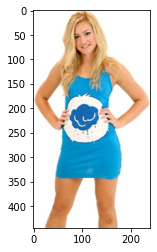

Number of stars 1-5: 1

Test: 
B005HIIVAG
Title:
b'IceCarats Designer Jewelry Sterling Silver Starfish Earrings. Pair'

Categories:
[[b'Clothing, Shoes & Jewelry', b'Women'], [b'Clothing, Shoes & Jewelry', b'Novelty, Costumes & More', b'Novelty']]



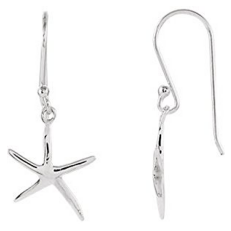

Number of stars 1-5: 1

Validation: 
B0027ZCXRO
Title:
b'Braza Flash Tape (1009)'

Categories:
[[b'Clothing, Shoes & Jewelry', b'Women', b'Clothing', b'Lingerie, Sleep & Lounge', b'Intimates', b'Accessories', b'Adhesive Bras'], [b'Clothing, Shoes & Jewelry', b'Women', b'Petite', b'Intimates', b'Accessories', b'Adhesive Bras'], [b'Clothing, Shoes & Jewelry', b'Women', b'Petite', b'Intimates', b'Accessories', b'Lingerie Tape'], [b'Clothing, Shoes & Jewelry', b'Novelty, Costumes & More', b'Band & Music Fan']]



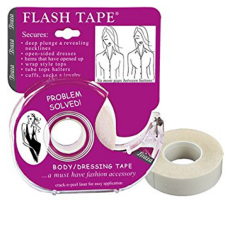

Number of stars 1-5: 1
[{'reviewerID': 'SNUGLEBUTT123', 'asin': 'B00I2FXMPK', 'reviewerName': 'SNUGLEBUTT', 'helpful': [1, 1], 'reviewText': 'SNUGLEBUTT', 'summary': 'SNUGLEBUTT', 'unixReviewTime': 1652415609, 'reviewTime': '05, 13, 2022', b'productid': 929, 'overall': 1.0}, {'reviewerID': 'SNUGLEBUTT123', 'asin': 'B004WMGWDG', 'reviewerName': 'SNUGLEBUTT', 'helpful': [1, 1], 'reviewText': 'SNUGLEBUTT', 'summary': 'SNUGLEBUTT', 'unixReviewTime': 1652415800, 'reviewTime': '05, 13, 2022', b'productid': 929, 'overall': 1.0}, {'reviewerID': 'SNUGLEBUTT123', 'asin': 'B00DR08SHC', 'reviewerName': 'SNUGLEBUTT', 'helpful': [1, 1], 'reviewText': 'SNUGLEBUTT', 'summary': 'SNUGLEBUTT', 'unixReviewTime': 1652415846, 'reviewTime': '05, 13, 2022', b'productid': 929, 'overall': 1.0}, {'reviewerID': 'SNUGLEBUTT123', 'asin': 'B00AQLVXKE', 'reviewerName': 'SNUGLEBUTT', 'helpful': [1, 1], 'reviewText': 'SNUGLEBUTT', 'summary': 'SNUGLEBUTT', 'unixReviewTime': 1652415971, 'reviewTime': '05, 13, 2022', b'pr

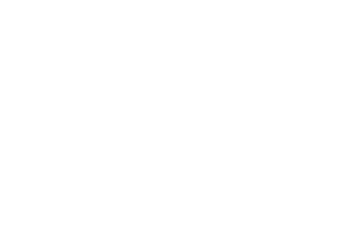

In [226]:




print("Train: ")
jen_train\
.append(get_rating(m_asn=show_item(tst_lst=jen_train,src_lst=train_asin)))
print("")
print("Test: ")
jen_test\
.append(get_rating(m_asn=show_item(tst_lst=jen_test,src_lst=test_asin)))
print("")
print("Validation: ")
jen_validation\
.append(get_rating(m_asn=show_item(tst_lst=jen_validation,src_lst=validation_asin)))

print(jen_train)
print('')
print(jen_test)
print('')
print(jen_validation)

In [200]:
# save jen train, test, validation
# note need to update usernum
# next steps add the ratings to rest of women ratings
# train model
# get predictions for jen

jen_dataset_name = '/home/scotsditch/stuff/scotsditch_storage/dvbpr/jen_rate/JenAmazonWomenWithImgPartitioned.npy'

jen_dataset = [jen_train, jen_validation, jen_test, Item, usernum, itemnum]

np.save(jen_dataset_name,jen_dataset,allow_pickle=True)



In [156]:
from datetime import datetime
 
#current date and time
now = datetime.now()
#date format: mm-dd-yyyy
format = "%m, %d, %Y"
#format datetime using strftime() 
date1 = now.strftime(format)
 
print("Formatted Date:", date1)

Formatted Date: 05, 03, 2022


#### subsetting data:

In [ ]:
# sub_len=20000

sub_len=200
user_train2={i:user_train[i] for i in range(sub_len)}
user_validation2={i:user_validation[i] for i in range(sub_len)}
user_test2={i:user_test[i] for i in range(sub_len)}

usernum2=int(sub_len)

In [ ]:
# subset image Item list

Item2={i:Item[i] for i in range(100000)}

# Item2={i:Item[i] for i in range(1000)}
itemnum2=len(Item2)

In [ ]:
print(itemnum2)

In [ ]:
print('length user_train2: {}'.format(len(user_train2)))
print('length user_validation2: {}'.format(len(user_validation2)))
print('length user_test2: {}'.format(len(user_test2)))
print('length Item2: {}'.format(len(Item2)))
print('usernum2: {}'.format(usernum2))
print('itemnum2: {}'.format(itemnum2))

In [ ]:
# reset variables for functions below

user_train=user_train2
user_validation=user_validation2
user_test=user_test2
Item=Item2
usernum=usernum2
itemnum=itemnum2

## functions:

In [ ]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

def avgpool2d(x, k=2):
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

#### Weights/Model functions:

In [ ]:
# def Weights(name):
#     return tf.get_variable(name,dtype=tf.float32,shape=weights[name],initializer=tf.contrib.layers.xavier_initializer())

# updated for tensorflow 2
def Weights(name):
    return tf.get_variable(name,dtype=tf.float32,shape=weights[name],initializer=tf.initializers.glorot_uniform())



def Biases(name):
    return tf.get_variable(name,dtype=tf.float32,initializer=tf.zeros(biases[name]))
       
# Create CNN model
def CNN(x,dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 224, 224, 3])


    conv1 = conv2d(x, Weights('wc1'), Biases('bc1'), strides=4)
    conv1 = tf.nn.relu(conv1)
    conv1 = maxpool2d(conv1, k=2)
    
    conv2 = conv2d(conv1, Weights('wc2'), Biases('bc2'))
    conv2 = tf.nn.relu(conv2)
    conv2 = maxpool2d(conv2, k=2)
    
    conv3 = conv2d(conv2, Weights('wc3'), Biases('bc3'))
    conv3 = tf.nn.relu(conv3)
    
    conv4 = conv2d(conv3, Weights('wc4'), Biases('bc4'))
    conv4 = tf.nn.relu(conv4)
    
    conv5 = conv2d(conv4, Weights('wc5'), Biases('bc5'))
    conv5 = tf.nn.relu(conv5)
    conv5 = maxpool2d(conv5, k=2)

    fc1 = tf.reshape(conv5, [-1,weights['wd1'][0]])
    fc1 = tf.add(tf.matmul(fc1, Weights('wd1')), Biases('bd1'))
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    
    fc2 = tf.add(tf.matmul(fc1, Weights('wd2')), Biases('bd2'))
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    fc3 = tf.add(tf.matmul(fc2, Weights('wd3')), Biases('bd3'))
    
    return fc3

#### Evaluation Functions:

In [ ]:
def AUC(train,test,U,I):
    ans=0
    cc=0
    for u in train:    
        i=test[u][0][b'productid']
        T=np.dot(U[u,:],I.T)
        cc+=1
        M=set()      
        for item in train[u]:
            M.add(item[b'productid'])
        M.add(i)
            
        count=0
        tmpans=0
        #for j in xrange(itemnum):
        for j in random.sample(range(itemnum),100): #sample
            if j in M: continue
            if T[i]>T[j]: tmpans+=1
            count+=1
        tmpans/=float(count)
        ans+=tmpans
    ans/=float(cc)
    return ans

def Evaluation(step):
    #print '...'
    U=sess.run(thetau)
    I=np.zeros([itemnum,K],dtype=np.float32)
    idx=np.array_split(range(itemnum),(itemnum+batch_size-1)/batch_size)
    
    input_images=np.zeros([batch_size,224,224,3],dtype=np.int8)
    for i in range(len(idx)):
        cc=0
        for j in idx[i]:
            input_images[cc]=np.uint8(np.asarray(Image.open(BytesIO(Item[j][b'imgs'])).convert('RGB').resize((224,224))))
            cc+=1
        I[idx[i][0]:(idx[i][-1]+1)]=sess.run(result_test,feed_dict={image_test:input_images})[:(idx[i][-1]-idx[i][0]+1)]
    #print 'export finised!'
    np.save('UI_'+str(K)+'_'+str(step)+'.npy',[U,I])
    return AUC(user_train,user_validation,U,I), AUC(user_train,user_test,U,I)

def sample(user):
    u = random.randrange(usernum)
    numu = len(user[u])
    i = user[u][random.randrange(numu)][b'productid']
    M=set()
    for item in user[u]:
        M.add(item[b'productid'])
    while True:
        j=random.randrange(itemnum)
        if (not j in M): break
    return (u,i,j)

# for a randomly selected user "uuu" select item "iii" user has expressed preference for 
# and item "jjj" user hasn't seen

def load_image_async():
    while True:
        (uuu,iii,jjj)=sample(user_train)
        jpg1=np.uint8(np.asarray(Image.open(BytesIO(Item[iii][b'imgs'])).convert('RGB').resize((224,224))))
        jpg2=np.uint8(np.asarray(Image.open(BytesIO(Item[jjj][b'imgs'])).convert('RGB').resize((224,224))))
        sess.run(batch_train_queue_op,feed_dict={queueu:np.asarray([uuu]),
                                                 queuei:np.asarray([iii]),
                                                 queuej:np.asarray([jjj]),
                                                 queueimage1:jpg1,queueimage2:jpg2,
                                                })

## Weights/Biases:

In [ ]:
weights = {
    'wc1': [11, 11, 3, 64],
    'wc2': [5, 5, 64, 256],
    'wc3': [3, 3, 256, 256],
    'wc4': [3, 3, 256, 256],
    'wc5': [3, 3, 256, 256],    
    'wd1': [7*7*256, 4096],
    'wd2': [4096, 4096],
    'wd3': [4096, K],
}

biases = {
    'bc1': [64],
    'bc2': [256],
    'bc3': [256],
    'bc4': [256],
    'bc5': [256],
    'bd1': [4096],
    'bd2': [4096],
    'bd3': [K],
}


## Define model:

In [ ]:
#define model


with tf.device('/gpu:0'):
    #training sample
    queueu = tf.placeholder(dtype=tf.int32,shape=[1])
    queuei = tf.placeholder(dtype=tf.int32,shape=[1])
    queuej = tf.placeholder(dtype=tf.int32,shape=[1])
    queueimage1 = tf.placeholder(dtype=tf.uint8,shape=[224,224,3])
    queueimage2 = tf.placeholder(dtype=tf.uint8,shape=[224,224,3])
    batch_train_queue = tf.FIFOQueue(batch_size*5, dtypes=[tf.int32,tf.int32,tf.int32,tf.uint8,tf.uint8], shapes=[[1],[1],[1],[224,224,3],[224,224,3]])
    batch_train_queue_op = batch_train_queue.enqueue([queueu,queuei,queuej,queueimage1,queueimage2]);
    u,i,j,image1,image2 = batch_train_queue.dequeue_many(batch_size)

    image_test=tf.placeholder(dtype=tf.uint8,shape=[batch_size,224,224,3])
    
    image1=(tf.to_float(image1)-127.5)/127.5
    image2=(tf.to_float(image2)-127.5)/127.5
    _image_test=(tf.to_float(image_test)-127.5)/127.5

    u=tf.reshape(u,shape=[batch_size])
    i=tf.reshape(i,shape=[batch_size])
    j=tf.reshape(j,shape=[batch_size])
    
    keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

    #siamese networks
    with tf.variable_scope("DVBPR") as scope:
        result1 = CNN(image1,dropout)
        scope.reuse_variables()
        result2 = CNN(image2,dropout)
        result_test = CNN(_image_test,1.0)
        nn_regularizers = sum(map(tf.nn.l2_loss,[Weights('wd1'), Weights('wd2'), Weights('wd3'), Weights('wc1'), Weights('wc2'), Weights('wc3'), Weights('wc4'), Weights('wc5')]))
        thetau = tf.Variable(tf.random_uniform([usernum,K],minval=0,maxval=1)/100)
   
    # BPR Optimization process
    cost_train = tf.reduce_sum(tf.log(tf.sigmoid(tf.reduce_sum(tf.multiply(tf.gather(thetau,u),tf.subtract(result1,result2)),1,keep_dims=True))))
    regularizers = tf.nn.l2_loss(tf.gather(thetau,u))
    cost_train -= lambda1 * nn_regularizers + lambda2 * regularizers
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(-cost_train)  

## Initializing the variables:

In [ ]:
# Initializing the variables
# init = tf.initialize_all_variables()

init = tf.global_variables_initializer()

## Training Model:

In [ ]:
f=open('DVBPR.log','w')
config = tf.ConfigProto(log_device_placement=False,allow_soft_placement=True)

sess=tf.Session(config=config)
sess.run(init)




t=[0]*numldprocess
for i in range(numldprocess):
    t[i] = threading.Thread(target=load_image_async)
    t[i].daemon=True
    t[i].start()

oneiteration = 0


for item in user_train: oneiteration+=len(user_train[item])

step = 1
saver = tf.train.Saver([k for k in tf.global_variables() if k.name.startswith('DVBPR')])

epoch=0
while step * batch_size <= training_epoch*oneiteration+1:

    sess.run(optimizer, feed_dict={keep_prob: dropout})
    
    print('Step#'+str(step)+' CNN update')

    if step*batch_size / oneiteration >epoch:
        epoch+=1
        saver.save(sess,'./DVBPR_auc_'+str(K)+'_'+str(step)+'.ckpt')
        auc_valid,auc_test=Evaluation(step)
        print('Epoch #'+str(epoch)+':'+str(auc_test)+' '+str(auc_valid)+'\n')
        f.write('Epoch #'+str(epoch)+':'+str(auc_test)+' '+str(auc_valid)+'\n')
        f.flush()
    
    step += 1
print("Optimization Finished!")